<a href="https://colab.research.google.com/github/afit-csce623-master/demos/blob/main/demo_scaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This tutorial developed by W. Blair Watkinson II
# Apr 30, 2021

# Developed in support of education and research activities at 
# the Air Force Institute of Technology and the CSCE 623
# Machine Learning course

# For changes or questions, contact warren.watkinson@afit.edu

# MIT License

# Copyright (c) 2021 W. Blair Watkinson II

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Data Scaling and Transformation

This tutorial demonstrates various techniques for data scaling and transforming for machine learning.

## Generate regression data

The `generate_data` function generates gaussian, uniform, and categorical data and calculates a regression target. It also optionally exponentiates the target values. The function is provided for your review but the particulars are beyond the scope of this tutorial.

### Data generation function

In [2]:
import numpy as np
import pandas as pd
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex

def generate_data(random_state, n_samples, 
                  n_gaussian_features, g_feature_mean_range, g_feature_sd_range,
                  n_uniform_features, u_feature_range,
                  categories, exponential_target, relative_noise):

    coefficient_range = [0, 5]

    X = pd.DataFrame()

    # generate gaussian features
    for idx in range(n_gaussian_features):
        X[f'G{idx+1}'] = random_state.normal(
            loc = random_state.uniform(*g_feature_mean_range), 
            scale = random_state.uniform(*g_feature_sd_range), 
            size = n_samples)


    # generate uniform features
    for idx in range(n_uniform_features):
        X[f'U{idx+1}'] = random_state.uniform(*u_feature_range, n_samples)

    # generate categorical features
    for idx, category_set in enumerate(categories):
        X[f'C{idx+1}'] = random_state.choice(category_set, n_samples)

    y = pd.DataFrame()
    y[0] = np.zeros(n_samples)


    # create coefficient array
    coef = np.zeros(n_gaussian_features 
                    + sum([len(category_set) for category_set in categories]) 
                    + n_uniform_features)
    
    # calculate targets using coefficients
    coef_pos = 0
    for idx, column in enumerate(X.columns):

        # add weighted gaussian and uniform features
        if column[0] == 'G' or column[0] == 'U':
            coef[coef_pos] = random_state.uniform(*coefficient_range)
            coef_pos += 1
            y[0] += X[column] * coef[idx]

        # add weighted category values
        elif column[0] == 'C':
            temp = np.zeros(n_samples)

            # first build array of weights corresponding to array of categories,
            # with each category mapping to a particular weight
            # the principal here is that if you have 2 categories, "ford" and "chevy",
            # you can add 3.5 for ford and 7.6 for chevy to the target, but we do it
            # in a way that takes advantage of broadcasting
            for category_val in categories[int(column[1:])-1]:
                coef[coef_pos] = random_state.uniform(*coefficient_range)
                temp[X[column] == category_val] = coef[coef_pos]
                coef_pos += 1

            # add array to target
            y[0] += temp

    # add an intercept, or bias
    intercept = random_state.uniform(g_feature_mean_range[1])
    y[0] += intercept

    if exponential_target: # if target has an exponential scale, exponentiate
        y[0] = np.exp((y[0] + abs(y[0].min())) / 10)

    if relative_noise > 0:
        y[0] += random_state.normal(y[0], y[0]/relative_noise)

    return X, y, coef, intercept

## Generate data

Using the above function, we generate data with 2000 samples and 7 features: 3 with a normal distribution, 2 with a uniform distribution, and 2 with a categorical distribution.

In [3]:
random_state = np.random.RandomState(623)

n_samples = 2000
n_gaussian_features = 3
n_uniform_features = 2
g_feature_mean_range = [1, 5]
g_feature_sd_range = [1, 3]
u_feature_range = [0,5]
categories = [['a', 'b', 'c'], ['v', 'w', 'x', 'y', 'z']]

X, y, coef, intercept = generate_data(random_state, 
                                      n_samples, 
                                      n_gaussian_features, g_feature_mean_range, g_feature_sd_range, 
                                      n_uniform_features, u_feature_range,
                                      categories, True, 0)

In [4]:
display(f'X: ', X)
display(f'y: ', y)

'X: '

,G1,G2,G3,U1,U2,C1,C2
0,6.754904,4.383600,3.699102,3.145859,1.678750,b,y
1,5.834529,2.478083,6.842155,0.110131,0.211036,b,w
2,-0.019920,5.148346,4.701757,0.418466,1.353766,b,w
3,6.100747,4.835442,2.565607,1.498564,0.080699,c,w
4,4.401672,2.800146,5.062265,3.333927,0.122657,b,v
...,...,...,...,...,...,...,...
1995,6.402820,5.245178,2.028098,4.111470,1.527076,a,w
1996,1.247847,0.261258,4.696588,2.271154,0.840323,c,z
1997,3.194544,1.267475,6.689624,0.002862,4.864324,b,w
1998,1.986392,2.687095,3.700734,4.526004,2.659952,b,x


'y: '

,0
0,1281.934128
1,348.658678
2,101.031358
3,351.007019
4,356.722461
...,...
1995,1228.936739
1996,73.939916
1997,206.961752
1998,400.755550


## Sequester test data

Before analyzing our dataset, we will first sequester test data using the `train_test_split` function of the `scikit-learn` library.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state)

## Analyze Data

Having removed our test data, we'll analyze the training set. A full analysis will be much more thorough, which will evaluate correlation and statistics for each feature, but for our purposes, we'll simply look at the histogram of each feature and the target.

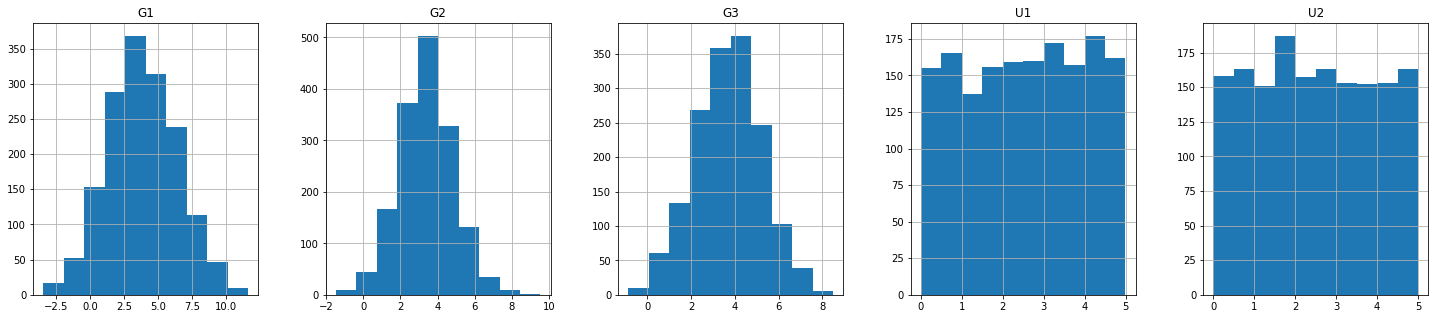

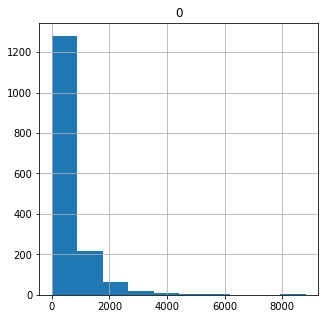

In [6]:
import matplotlib.pyplot as plt

X_train.hist(layout=(1,5), figsize=(25,5))
plt.show()

y_train.hist(figsize=(5,5))
plt.show()

Examining the histograms, we notice that the `X` features include 3 features with a normal distribution and 2 features with a uniform distribution. Also, we see that in the target the majority of the data are in the low portion of the range, with a long tail.

## Naive model

In the code cell below, we transform the two categorical features (not displayed above) to basic ordinal data ('a' is converted to 0.0, 'b' is converted to 1.0, etc). Then, we attempt to fit a linear model. We note the root mean squared error is very large and the $R^2$ score is low. This "naive" model serves as a baseline against which we can compare the performance of a model that uses pre-processed data.

We will not discuss the details for transforming the training and test data at this point. Instead, we will explore different methods to scale and transform data. Then, when we select and apply the appropriate transformations to our data, we'll get into the details of the `scikit-learn` library for transformations.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


transformer = ColumnTransformer(
    transformers=
        [('categorical', OrdinalEncoder(), ['C1', 'C2'])],
        remainder='passthrough'
    )

# transform training data
X_train_transformed = transformer.fit_transform(X_train)

# fit linear model
linear = LinearRegression()
linear.fit(X_train_transformed, y_train)

# transform test data
X_test_transformed = transformer.transform(X_test)

# use model to make predictions, calculate error
y_pred = linear.predict(X_test_transformed)
rmse = mean_squared_error(y_test, y_pred)
r2 = linear.score(X_test_transformed, y_test)

display(md(f'RMSE: {rmse:.4e}'))
display(md(f'$R^2$: {r2:.4f}'))



RMSE: 3.2826e+05

$R^2$: 0.5761

## Data transformation methods

Before scaling and transforming our data, we will first review common scaling and transformation techniques.

In our data analysis, we note that both the `X` features and `y` targets have a relatively gaussian distribution. Many machine learning tasks require input data to have the same relative scale. Common scaling and normalization tools include:

- Data normalization rescales all data from its original range to $[0, 1]$:

  $x_i' = \frac{(x_i - x_{min})}{(x_{max} - x_{min})}$

  where $x$ represents one of the features, and $x_i$ is the $i^{th}$ observation of feature $x$. $x_{min}$ and $x_{max}$ are the minimum and maximum observations of feature $x$. $x_i'$ is the new feature value within the range $[0, 1]$. The `scikit-learn` package provides a utility for scaling all feature values with the [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) and a slight variation, the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html#sklearn.preprocessing.MaxAbsScaler). These techniques preserve the original distribution of the data and may be suitable for sparse data. One drawback of normalization is that extreme outliers will cause data to be squished toward one ond of the scale or another during normalization.

- Data standardization, also known as Z-score, is a scaling technique that ensures that all data have a mean of zero and unit variance:

  $x_i' = \frac{x_i - \mu_x}{\sigma_x}$

 where $\mu_x$ is the mean of $x$ and $\sigma_x$ is the standard deviation of $x$. The new feature value $x_i'$ represents a feature value such that all $x'$ have a zero mean and a standard deviation of 1. The [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) of the `scikit-learn` library provides this functionality. This technique is suitable for data that already have a normal distribution.

- Other methods of scaling and transforming data are common, including clipping, which clips all values that exceed a fixed value. Clipping is provided for in the `scikit-learn` [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) class. Log scaling is useful when data are not well distributed over the range with a high frequency of lower values with a long tail. Log scaling produces the power law distribution and can generate a more uniform distribution for data with a long tail. Both of these scaling methods are beyond the scope of this tutorial, but you can read more about them at [Google's Machine Learning Data Prep course](https://developers.google.com/machine-learning/data-prep/transform/normalization). Both clipping and log scaling can be followed with either normalization or standardization.

- Ordinal encoding is a technique applied to categorical data that assigns each category an ordinal value, such as {"cat": 3, "dog": 4}. A major drawback of ordinal encoding is that it implies a numerical relationship between categories of data where often none exists. On the other hand, when a natural ordering exists, such as in ordinal data, "1st", "2nd", "3rd",  the ordinal encoding approach may be appropriate. `scikit-learn` function [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) class provides this functionality. 

  Although ordinal encoding shouldn't be used on a features where there is no numerical relationship between the feature values for model training, it can be useful for data analysis. For example, if ordinal encoding is applied to a feature, a histogram will show the distribution of that feature among the categories.

  It may be appropriate to use ordinal encoding on categorical target data. For encoding `y` target category values, `scikit-learn` has provided the [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder) class.

- One-Hot encoding is appropriate for categorical variables where no numerical relationship exists. One-hot encoding takes the approach by assigning every observation a bit for every possible category. All bits are "turned off" except the one associated with the observation category. For example, "cat" and "dog" categories could be represented as $[1, 0]$ and $[0, 1]$, respectively. `scikit-learn` provides a one-hot encoding transformation in the [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) class

## Data scaling and transformation

Returning to our own data, we will select and apply the appropriate transformation for each feature.

- We observe that features `G1`, `G2`, and `G3` all have something that reflects a normal distribution. We will plan to apply a standardization, or Z-score, transformation to these features.
- Features `U1` and `U2` have a uniform distribution. We will normalize this data between -1 and 1 without changing the relative distance between observations.
- `C1` and `C2` are categorical data which we'll encode with one-hot encoding.
- Finally, the target exhibits a long tail, and we'll use log scaling to create a power distribution, which we will then normalize.

The following subsections demonstrate the effects of each these transformations. We will ultimately apply these transformations through a `scikit-learn` `Pipeline` after these demonstrations.

### Transform gaussian data

Below, we compare the original `X` gaussian features with the result of those features after being standardized.

We use the `scikit-learn` [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class to apply the transformation. Below, we use the `fit_transform` method to fit the scaler and to transform the data in one step. `fit` sets the parameters for the scaler, namely the mean and the standard deviation. `transform` applies the transformation to the data and returns the transformed dataset. We provide the specific columns to be transformed to the `fit_transform` method. If we were to try and pass the entire DataFram `X_train`, the scaler will attempt to conduct a standard transform on all of the columns in `X_train`, and we would we receive an error when the scaler encountered our string categorical data.

In our case, we convert the result back into a DataFrame so that we can visualize the histograms. 

Note that you would never fit the scaler to the test data. We only fit our scalers to the training data, and then we apply those scalers to both the training data and the test data.

In the histograms below, we note that the histograms retained the same shape, confirming our hypothesis that the data are essentially gaussian. We observe in the histograms of the transformed data that the mean has been shifted to 0 and the variance is approximately 1.

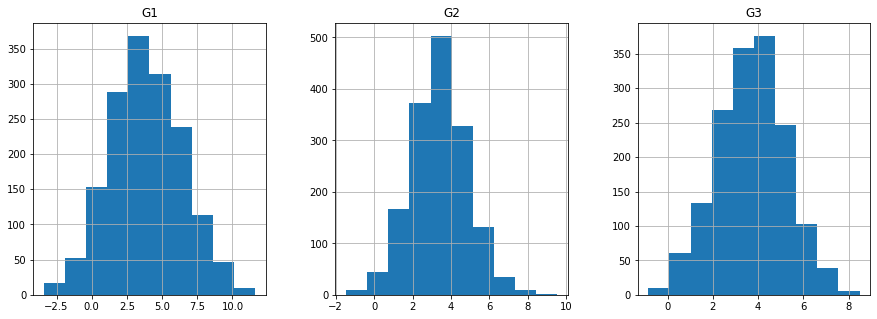

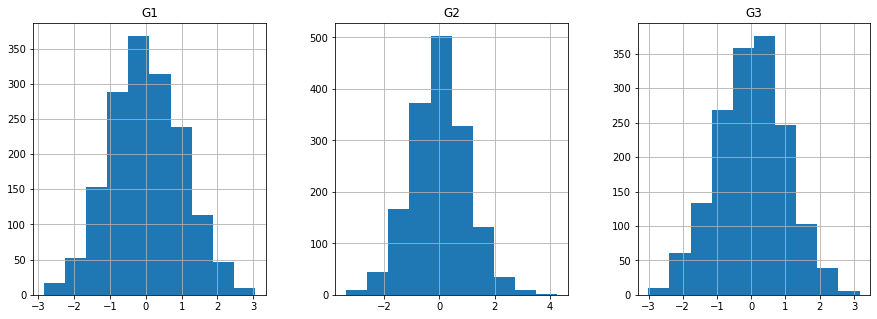

In [8]:
from sklearn.preprocessing import StandardScaler

X_train[['G1', 'G2', 'G3']].hist(layout=(1,3), figsize=(15,5))
plt.show()

scaler = StandardScaler()
X_train_gaussian = pd.DataFrame(scaler.fit_transform(X_train[['G1', 'G2', 'G3']]), columns=['G1', 'G2', 'G3'])
X_train_gaussian.hist(layout=(1,3), figsize=(15,5))
plt.show()

### Transform uniform data

Likewise, we transform the data having a uniform distribution. In this case, we use the [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). The default range of the MinMaxScaler is $[0, 1]$; however, we've used $[-1, 1]$ below to remain somewhat consistent with the mean of the gaussian features.

We note the effect of the transformation is to shift and scale all features to the range $[-1, 1]$.

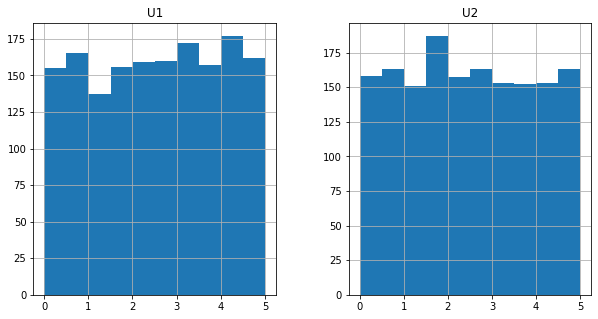

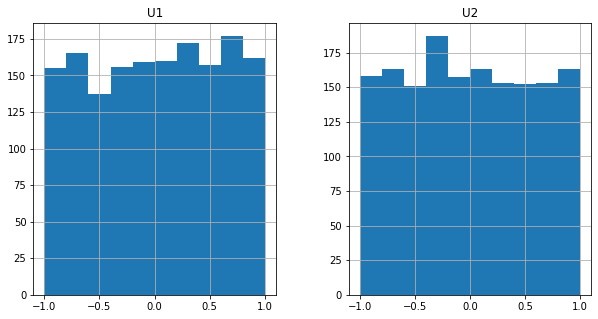

In [9]:
from sklearn.preprocessing import MinMaxScaler

X_train[['U1', 'U2']].hist(layout=(1,2), figsize=(10,5))
plt.show()

scaler = MinMaxScaler((-1, 1))
X_train_uniform = pd.DataFrame(scaler.fit_transform(X_train[['U1', 'U2']]), columns=['U1', 'U2'])
X_train_uniform.hist(layout=(1,2), figsize=(10,5))
plt.show()

### Transform categorical data

For our categorical data, we use the [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). This snippet demonstrates how easy it is to transform categorical data into a one-hot encoding. Recall that the `C1` feature has three categories `{a, b, c}` and that the `C2` feature has five features `{v, w, x, y, z}`. We see in the transformed columns that column 0 is "hot" for all 'a' observations. Likewise, column 1 corresponds to 'b' observations, and so forth.

In [10]:
from sklearn.preprocessing import OneHotEncoder

display(X_train[['C1', 'C2']])

enc = OneHotEncoder()
enc.fit(X_train[['C1', 'C2']])
X_train_onehot = enc.transform(X_train[['C1', 'C2']]).toarray()
display(pd.DataFrame(X_train_onehot))

,C1,C2
1107,c,v
1719,c,z
735,b,y
1833,c,x
581,b,w
...,...,...
61,b,w
1001,b,v
222,b,x
1145,a,y


,0,1,2,3,4,5,6,7
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1595,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1596,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1597,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1598,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Transform target data

Here we will transform our target data. Above, we noted that the target values are heavily represented on the lower end of the spectrum, with increasingly sparse representation in the higher end of the range of `y`.

When we take the natural log of `y`, the distribution of `y` appears to take on a normal distribution. We can then standardize the data so that it has a mean of zero and a unit variance. Note that the shapes of first two histograms are identical.

For demonstration purposes, we also display a power transform  using the [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html) function. The PowerTransformer function uses the Yeo-Johnson transform by default. When we compare the power transform histogram with the previous two histograms, we see that the shape of power transform is very slightly different than the other two, but it does have a zero mean and a unit variance.

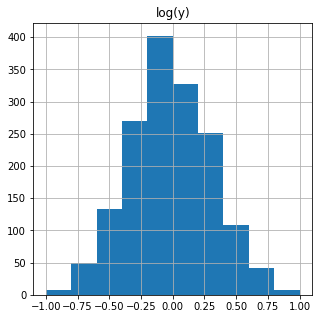

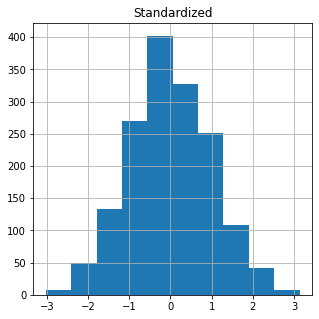

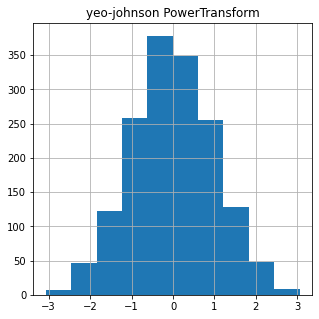

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

# transform y => log(y)
y_train_log = pd.DataFrame(scaler.fit_transform(np.log(y_train)), columns=['log(y)'])
y_train_log.hist(layout=(1,1), figsize=(5,5))
plt.show()

# transform log(y) => standardized
scaler = StandardScaler()
y_train_gaussian = pd.DataFrame(scaler.fit_transform(y_train_log), columns=['Standardized'])
y_train_gaussian.hist(layout=(1,1), figsize=(5,5))
plt.show()

# transform y => PowerTransform (yeo-johnson)
scaler = PowerTransformer()
y_train_gaussian = pd.DataFrame(scaler.fit_transform(y_train), columns=['yeo-johnson PowerTransform'])
y_train_gaussian.hist(layout=(1,1), figsize=(5,5))
plt.show()

## Bringing it all together - Pipelines

Though we could fit and apply each transform individually to the training data as demonstrated above, we'd also need to remember to apply each transform to the test data.

A better approach is to use a workflow provided by `scikit-learn`. Specifically, we'll use:
- A [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to impose a transform on each of the input data columns
- A [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to apply one or more transforms and assign a model type
- A [TransformedTargetRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html) to take the log and then standardize our data.

This workflow can be applied in different ways depending on the problem. Each part can be used independently, or they can be used collectively, as in our problem. The TransformedTargetRegressor object is particularly helpful as it will apply the desired transforms to the `y` target to fit the model, but it will automatically inverse the transform when calculating the error and predicted targets.

### ColumnTransformer



In the cell below, we apply a ColumnTransformer to the input data. In a single command, we set up all the features for transformation. This command does not actually conduct the transformation, but it only loads the transformation. `transformer.fit(X_train)` will fit the individual scalers, `transformer.transform(X_train)` will apply the transform and return the transformed dataset. `transformer.fit_transform(X_train)` will fit the scalers and return the transformed data in a single step.

Instead of fitting and applying our transformers, we will instead incorporate them into a Pipeline.

In [12]:
from sklearn.compose import ColumnTransformer

transformer = ColumnTransformer(transformers = 
    [('z', StandardScaler(), ['G1', 'G2', 'G3'] ),
     ('normalize', MinMaxScaler(feature_range=(-1, 1)), ['U1', 'U2']),
     ('one_hot', OneHotEncoder(), ['C1', 'C2'])
    ]
)

### Pipeline

We can setup a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) incorporating the column transformer and applying a linear regression model.

Some notes and caveats about pipelines:
- When you have multiple transforms to impose on the same column, you cannot apply them in the same column transformer. Instead, you must create multiple column transforms and then apply them sequentially in a pipeline
- The Pipeline object generates a dictionary such that you can access the `model` with `pipeline['model']`. Likesie, you can access the individual standard scaler used in the column transform, you can use `pipeline['transformer']['z'].

We can conduct use the standard model methods of `fit`, `predict`, `predict_proba`, `score`, etc, using the pipeline which will automatically transform the input data and then use the selected model to `fit`, `predict`, etc, the data.

Because we need to transform our target data, we will not apply the pipeline just yet. Instead, we'll incorporate the pipeline in a TransformedTargetRegressor.

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

pipeline = Pipeline(steps=
    [('transformer', transformer),
     ('model', LinearRegression())]
)

### TransformedTargetRegressor

Here, we incorporate our pipeline into a TransformedTargetRegressor.

The idea behind a TransformedTargetResgressor is to apply a transform to the target data for the purpose of fitting the model, but then automatically invert the transform when calculating the score and `y` predictions.

TransformedTargetRegressor requires either a transformer or two functions: `func` that conducts the transform and `inverse_func` that conducts the inverse of the transform. We introduce a global variable `target_standard_scaler` to keep track of the StandardScaler object that is used by both functions. The more correct way to implement this would be to create a class and to store the StandardScaler() as a property of objects instantiated by that class. Nonetheless, this MWE demonstrates the concepts.

The TransformedTargetRegressor references the pipeline as its estimator, which means that it will use the column transformations and the linear model used in that pipeline. The `func` transformer imposes a standardization (z-score) on the natural log of the `y` target values. The inverse function first inverts the standardization of the data and then returns the natural exponentiation of the un-standardized data.

This model can then be used as any other model to `fit` to training data `predict` target values, `score` its performance using test data.


In [14]:
from sklearn.compose import TransformedTargetRegressor

target_standard_scaler = StandardScaler()

def standard_log(y):
    return target_standard_scaler.fit_transform(np.log(y))

def exp_reskew(y):
    y_reskew = target_standard_scaler.inverse_transform(y)
    return np.exp(y_reskew)

model = TransformedTargetRegressor(
    regressor = pipeline,
    func = standard_log,
    inverse_func = exp_reskew
)

The code below has exactly the same effect as the code above, however, it uses a custom class, `StandardLog` to avoid the need for a global variable.

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin

class StandardLog( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self):
        self._scaler = StandardScaler() 
    
    # return fitted scaler    
    def fit( self, X, y = None ):
        return self._scaler.fit(np.log(X)) 
    
    # return transformed data
    def transform( self, X, y = None ):
        return self._scaler.transform(np.log(X))

    def fit_transform(self, X, y = None):
        return self._scaler.fit_transform(np.log(X))

    def inverse_transform(self, X, y = None):
        y_reskew = self._scaler.inverse_transform(X)
        return np.exp(y_reskew)
    

## Evaluate model

Using the various `scikit-learn` tools, we evaluate the performance of our model.

First, we observe that the 10-fold cross-validated error on the training set is 0.0. When we fit the model to the training data and evaluate it on the test data, we note a 0.0 RMSE and a 1.0 $R^2$ value.

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
display(md(f'CV RMSE: {-np.mean(scores):.4f}'))

model.fit(X_train, y_train)
r2 = model.score(X_test, y_test)
display(md(f'$R^2$: {r2:.4f}'))

y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
display(md(f'RMSE: {rmse:.4f}'))

CV RMSE: 0.0000

$R^2$: 1.0000

RMSE: 0.0000

## Visualize benefit of transforming target values

Here we provide a brief demonstration of the benefit of transforming the target values. Our target values originally appeared to have a logarithmic distribution. Linear models will not perform well with such data. By transforming our target data to a power scale, we were able to more effectively fit our model.

The plot on the left demonstrates the predicted values vs actual values our best model on data where we do not use a power scale for our target data. The plot on the right shows the model performance when we transform our target data.

Incidentally, to calculate the predicted values without transforming the y values, we use the pipeline as our model. Recall that the pipeline only transforms the input values and then uses the linear model. To calculate the predicted values after the transform, we use the transformed target regressor as our model.

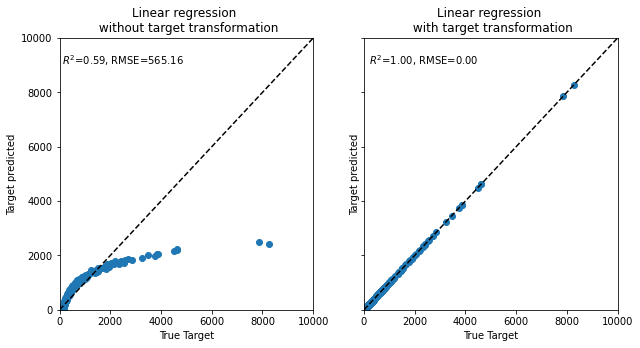

In [17]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(10,5))

# untransformed targets
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# plot results
ax0.scatter(y_test, y_pred)
ax0.plot([0, 10000], [0, 10000], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Linear regression \n without target transformation')
ax0.text(100, 9000, f'$R^2$={r2_score(y_test, y_pred):.2f}, RMSE={mean_squared_error(y_test, y_pred, squared=False):.2f}')

ax0.set_xlim([0, 10000])
ax0.set_ylim([0, 10000])


# transformed targets
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# plot results
ax1.scatter(y_test, y_pred)
ax1.plot([0, 10000], [0, 10000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Linear regression \n with target transformation')
ax1.text(200, 9000, f'$R^2$={r2_score(y_test, y_pred):.2f}, RMSE={mean_squared_error(y_test, y_pred, squared=False):.2f}')

ax1.set_xlim([0, 10000])
ax1.set_ylim([0, 10000])

plt.show()

# Complete Demo

What follows is the complete demo. We introduce noise in our data. Although the RMSE is very high, note that the scale of our `y` values is in the range of $[0-8,000]$. Also, note our high $R^2$ measure.

CV RMSE: 524.6138

$R^2$: 0.9342

RMSE: 448.0009

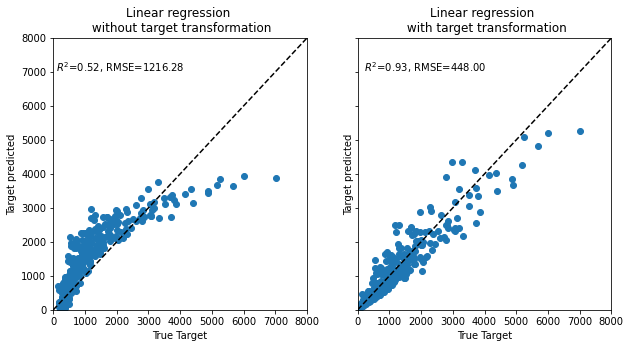

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# create StandardLog class
class StandardLog( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self):
        self._scaler = StandardScaler() 
    
    # return fitted scaler    
    def fit( self, X, y = None ):
        return self._scaler.fit(np.log(X)) 
    
    # return transformed data
    def transform( self, X, y = None ):
        return self._scaler.transform(np.log(X))

    def fit_transform(self, X, y = None):
        return self._scaler.fit_transform(np.log(X))

    def inverse_transform(self, X, y = None):
        y_reskew = self._scaler.inverse_transform(X)
        return np.exp(y_reskew)


# generate data
random_state = np.random.RandomState(623)

n_samples = 2000
n_gaussian_features = 3
n_uniform_features = 2
g_feature_mean_range = [1, 5]
g_feature_sd_range = [1, 3]
u_feature_range = [0,5]
categories = [['a', 'b', 'c'], ['v', 'w', 'x', 'y', 'z']]

X, y, coef, intercept = generate_data(random_state, 
                                      n_samples, 
                                      n_gaussian_features, g_feature_mean_range, g_feature_sd_range, 
                                      n_uniform_features, u_feature_range,
                                      categories, True, 2)


# sequester test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state)

# create data pipeline
transformer = ColumnTransformer(transformers = 
    [('z', StandardScaler(), ['G1', 'G2', 'G3'] ),
     ('normalize', MinMaxScaler(feature_range=(-1, 1)), ['U1', 'U2']),
     ('one_hot', OneHotEncoder(), ['C1', 'C2'])
    ]
)

pipeline = Pipeline(steps=
    [('transformer', transformer),
     ('model', LinearRegression())]
)

model = TransformedTargetRegressor(
    regressor = pipeline,
    transformer = StandardLog(),
)


# calculate cv error
cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
display(md(f'CV RMSE: {-np.mean(scores):.4f}'))

# calculate r2 error
model.fit(X_train, y_train)
r2 = model.score(X_test, y_test)
display(md(f'$R^2$: {r2:.4f}'))

# calculate rmse error
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
display(md(f'RMSE: {rmse:.4f}'))


# plot predicted targets vs actual targets
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(10,5))

# untransformed targets
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# plot results
ax0.scatter(y_test, y_pred)
ax0.plot([0, 8000], [0, 8000], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Linear regression \n without target transformation')
ax0.text(100, 7000, f'$R^2$={r2_score(y_test, y_pred):.2f}, RMSE={mean_squared_error(y_test, y_pred, squared=False):.2f}')

ax0.set_xlim([0, 8000])
ax0.set_ylim([0, 8000])


# transformed targets
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# plot results
ax1.scatter(y_test, y_pred)
ax1.plot([0, 8000], [0, 8000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Linear regression \n with target transformation')
ax1.text(200, 7000, f'$R^2$={r2_score(y_test, y_pred):.2f}, RMSE={mean_squared_error(y_test, y_pred, squared=False):.2f}')

ax1.set_xlim([0, 8000])
ax1.set_ylim([0, 8000])

plt.show()